# Suppose 2 R0

In [1]:
# Defining parameters as stochastic function

# deaths in hospitals / total deaths
def frac_dh():
    return torch.tensor(3470. / 7594.)

# fraction of hospitalized 
def hh():
    return torch.tensor(0.05)

# inverse recovery time
def gamma():
    return torch.tensor(1. / 12.4)

# inverse incubation time 
def epsilon():
    return torch.tensor(1. / 5.2)

# fatality rate in icu 
def dea():
    return torch.tensor(.5)

# population size
def n0():
    return torch.tensor(11000000.)

# population en MR/MRS + personnel soignant
def n0_MRS():
    return torch.tensor(400000.)

# e0 = i0 * factor
def e0_factor():
    return torch.tensor(37.)

# e0_MRS = i0_MRS * factor
def e0_MRS_factor():
    return torch.tensor(20.)

# size of the window for fitting Re's
def window():
    return torch.tensor(6.)

def i0():
    #return pyro.sample("i0", dist.Poisson(10))
    return torch.tensor(3.)

def drea():
    return dea()/ 5. 
    
def rrea():
    return (1 - dea())/20.
    
def hospi():
    return torch.tensor(0.0)

def gg():
    return torch.tensor(.75)

In [2]:
def SEIR(r0):   
    # Initial conditions
    n = [n0()] # Population totale
    i = [i0()] # Symptomatiques
    e = [i[0] * e0_factor()] # Asymptomatiques
    h = [torch.tensor(.0)] # Lits occupés hopital
    l = [torch.tensor(.0)] # Lits occupés USI
    r = [torch.tensor(.0)] # Immunisés
    m = [torch.tensor(.0)] # Morts (totaux)
    s = [n[-1] - e[-1] - i[-1] - r[-1]] # Sains
    
    # Simulate forward
    n_days = len(r0)
    
    hospi = 0.
    for day in range(n_days):
        lam = gamma() * r0[day]
        
        if day == 14:
            hospi = hh() / 7
            
        ds = -lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1]
        de = lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1] - epsilon() * e[-1]
        di = epsilon() * e[-1] - gamma() * i[-1] - hospi * i[-1]
        dh = hospi * i[-1] - gg() * h[-1] / 7 - (1 - gg()) * h[-1] / (4. + 2 * torch.tanh((l[-1]-500.)/300.))
        dl = (1 - gg()) * h[-1] / (4 + 2 * torch.tanh((l[-1]-500)/300)) - drea() * l[-1] - rrea() * l[-1]
        dr = gamma() * i[-1] + rrea() * l[-1] + gg() * h[-1] / 7
        dm = drea() * l[-1] 
        
        s.append(s[-1] + ds)
        e.append(e[-1] + de)
        i.append(i[-1] + di)
        h.append(h[-1] + dh)
        l.append(l[-1] + dl)
        if l[-1] > 1895:
            dm = dm + (l[-1] - 1895)
            l[-1] = torch.tensor(1895.)
        r.append(r[-1] + dr)
        m.append(m[-1] + dm)
        n.append(s[-1] + e[-1] + i[-1] + h[-1] + l[-1] + r[-1])
    return s, e, i, h, l, m, r
def SEIR_MRS(r0_mrs, n_futures=0, window=6):    
    # Smoothen and extend R0s
    
    # Initial conditions
    alpha = torch.tensor(0.15 / 10)
    lam = gamma() * 4.3
    
    n = [n0_MRS()]
    i = [torch.tensor(1.)]
    e = [i[-1] * e0_MRS_factor()]
    r = [torch.tensor(0.0)]
    s = [n[-1] - e[-1] - i[-1] - r[-1]]
    m = [torch.tensor(0.0)]
    
    # Simulate forward
    n_days = len(r0_mrs)
    
    for day in range(n_days):
        lam = gamma() * r0_mrs[day]
        
        ds = -lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1]
        de = lam * (i[-1] / 2 + e[-1]) * s[-1] / n[-1] - epsilon() * e[-1]
        di = epsilon() * e[-1] - (gamma() + alpha) * i[-1]
        dr = gamma() * i[-1]
        dm = alpha * i[-1]
        
        s.append(s[-1] + ds)
        e.append(e[-1] + de)
        i.append(i[-1] + di)
        r.append(r[-1] + dr)
        m.append(m[-1] + dm)
        n.append(s[-1] + e[-1] + i[-1] + r[-1])
        
    return s, e, i, m, r

In [3]:
from pyro.infer.mcmc import MCMC, NUTS
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from torch.distributions import constraints

import seaborn

(source: [wikipedia covid-19 Belgique](https://fr.wikipedia.org/wiki/Pand%C3%A9mie_de_Covid-19_en_Belgique))
- 11 Mars arrêt des visites en mrs. (13)
- 16 Mars plus de cours. (18)
- 18 Mars confinement. (20)
- 20 avril magasin de bricolage et pépinieriste ouvrent à nouveau. (22)

Nos données débutent au 28 février

In [4]:
date_r0_switch = 20
date_r0_switch_mrs = 13

In [5]:
from covid19be import load_data
data_df = load_data()

In [6]:
data_df[3:].head()

,n_hospitalized,n_hospitalized_in,n_hospitalized_out,n_icu,n_daily_deaths,date,n_deaths
4,0,0,0,0,0,2020-03-02,0
5,0,0,0,0,0,2020-03-03,0
6,0,0,0,0,0,2020-03-04,0
7,0,0,0,0,0,2020-03-05,0
8,0,0,0,0,0,2020-03-06,0


In [7]:
n_days = len(data_df)
n_days

63

In [8]:
nb_dirty_data = 4
n_useful_days = n_days - nb_dirty_data

In [9]:
n_useful_days

59

In [10]:
n_unpredictable_days = 4


In [11]:
mrs = True
noiser = lambda mu: dist.ZeroInflatedPoisson(torch.tensor(.0001), mu + 1)

In [12]:
def noiser(mu):
    #print(mu)
    if mu <= 0:
        print(mu)
    return dist.ZeroInflatedPoisson(torch.tensor(.0001), mu + 1)
    

In [13]:
def SEIR_full_model_bis(ret_data=False):    
    n_futures=0
    # Simulate
    r0_1 = pyro.sample("r0_1", dist.Uniform(torch.zeros(n_useful_days) + .2, 
                                            torch.ones(n_useful_days)*8.))
    # R0 fluctuates around its means that are given by r0_1 and r0_2
    r0 = dist.Uniform(r0_1 - .2, r0_1 + .2)()
    s_T, e_T, i_T, h_T, l_T, m_T, r_T = SEIR(r0)
    #print(r0)
    if mrs:
        r0_mrs_1 = pyro.sample("r0_mrs_1", dist.Uniform(torch.zeros(n_useful_days) + .2, torch.ones(n_useful_days)*8.))
        r0_mrs = dist.Uniform(r0_mrs_1 - .2, r0_mrs_1 + .2)()
    
        _, _, _, m_mrs_T, _ = SEIR_MRS(r0_mrs)
    for idx in range(n_useful_days):
        if idx > 16:
            if h_T[idx] < 0:
                print(h_T[idx])
            pyro.sample("h_%d" % idx, noiser(h_T[idx]))
            pyro.sample("l_%d" % idx, noiser(l_T[idx]))
            pyro.sample("m_%d" % idx, noiser(m_T[idx]))
            if mrs:
                pyro.sample("m_mrs_%d" % idx, noiser(m_mrs_T[idx]))
    if mrs and ret_data:
        return s_T, e_T, i_T, h_T, l_T, m_T, m_mrs_T, r_T, r0, r0_mrs
    if ret_data:
        return s_T, e_T, i_T, h_T, l_T, m_T, r_T, r0

In [14]:
data = {}
hospi = data_df['n_hospitalized']
l = data_df['n_icu']
m = data_df['n_deaths']
for idx in range(n_useful_days):
    if idx > 16:
        data["h_%d" % idx] = torch.tensor(hospi[idx] - l[idx], dtype=torch.float)
        data["l_%d" % idx] = torch.tensor(l[idx], dtype=torch.float)
        data["m_%d" % idx] = torch.tensor(m[idx]*frac_dh(), dtype=torch.float)
        if mrs:
            data["m_mrs_%d" % idx] = torch.tensor(m[idx]*(1-frac_dh()))


<ipython-input-14-995aa5173365>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data["m_%d" % idx] = torch.tensor(m[idx]*frac_dh(), dtype=torch.float)
<ipython-input-14-995aa5173365>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data["m_mrs_%d" % idx] = torch.tensor(m[idx]*(1-frac_dh()))


In [15]:
def r0_guide(ret_data=False):    
    a_r0_1 = pyro.param("a_r0_1", torch.ones(n_useful_days - n_unpredictable_days) * 4., constraint=constraints.positive)
    b_r0_1 = pyro.param("b_r0_1", torch.ones(n_useful_days - n_unpredictable_days) * 3., constraint=constraints.positive)
    a_r0_1 = torch.cat((a_r0_1, torch.ones(n_unpredictable_days) * a_r0_1[-1]))
    b_r0_1 = torch.cat((b_r0_1, torch.ones(n_unpredictable_days) * b_r0_1[-1]))

    r0_1 = pyro.sample("r0_1", dist.Uniform(a_r0_1, a_r0_1 + b_r0_1))
    if mrs:
        a_r0_mrs_1 = pyro.param("a_r0_mrs_1", torch.ones(n_useful_days - n_unpredictable_days) * 2., constraint=constraints.positive)
        b_r0_mrs_1 = pyro.param("b_r0_mrs_1", torch.ones(n_useful_days - n_unpredictable_days) * 4., constraint=constraints.positive)
        a_r0_mrs_1 = torch.cat((a_r0_mrs_1, torch.ones(n_unpredictable_days) * a_r0_mrs_1[-1]))
        b_r0_mrs_1 = torch.cat((b_r0_mrs_1, torch.ones(n_unpredictable_days) * b_r0_mrs_1[-1]))
        r0_mrs_1 = pyro.sample("r0_mrs_1", dist.Uniform(a_r0_mrs_1, a_r0_mrs_1 + b_r0_mrs_1))

    if ret_data:
        # R0 fluctuates around its means that are given by r0_1 and r0_2
        r0 = dist.Uniform(r0_1 - .2, r0_1 + .2)()

        s_T, e_T, i_T, h_T, l_T, m_T, r_T = SEIR(r0)
        #print(r0)
        if mrs:
            r0_mrs = dist.Uniform(r0_mrs_1 - .2, r0_mrs_1 + .2)()

            _, _, _, m_mrs_T, _ = SEIR_MRS(r0_mrs)
        for idx in range(n_useful_days):
            if idx > 16:
                pyro.sample("h_%d" % idx, noiser(h_T[idx]))
                pyro.sample("l_%d" % idx, noiser(l_T[idx]))
                pyro.sample("m_%d" % idx, noiser(m_T[idx]))
                if mrs:
                    pyro.sample("m_mrs_%d" % idx, noiser(m_mrs_T[idx]))
        if mrs and ret_data:
            return s_T, e_T, i_T, h_T, l_T, m_T, m_mrs_T, r_T, r0, r0_mrs
        if ret_data:
            return s_T, e_T, i_T, h_T, l_T, m_T, r_T, r0

In [16]:
pyro.clear_param_store()
# setup the optimizer
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = pyro.optim.Adam(adam_params)
svi = pyro.infer.SVI(model=pyro.condition(SEIR_full_model_bis, data=data),
                     guide=r0_guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())


In [17]:
%%time
losses, a,b  = [], [], []
num_steps = 20000
for t in range(num_steps):
    #print(svi.step(guess_R0, guess_R0_RMS))
    #print('r0 = ',pyro.param("a_r0"), pyro.param("b_r0"))
    losses.append(svi.step())
    if t % 100 == 0:
        print('r0 before lock-down ',pyro.param("a_r0_1"), pyro.param("a_r0_1") + pyro.param("b_r0_1"))
        print('r0 mrs before lock-down ',pyro.param("a_r0_mrs_1"), pyro.param("a_r0_mrs_1") + pyro.param("b_r0_mrs_1"))
        print(losses[-1])

r0 before lock-down  tensor([3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960,
        3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960,
        3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960,
        3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960,
        3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960,
        3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960, 3.9960,
        3.9960], grad_fn=<AddBackward0>) tensor([6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930,
        6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930,
        6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930,
        6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930,
        6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930,
        6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.9930, 6.

r0 before lock-down  tensor([2.9180, 2.9179, 2.9198, 2.9195, 2.9221, 2.9247, 2.9237, 2.9244, 2.9243,
        2.9223, 2.9250, 2.9198, 2.9243, 2.9241, 2.9251, 2.9224, 2.9210, 2.9198,
        2.9205, 2.9179, 2.9181, 2.9191, 2.9170, 2.9148, 2.9152, 2.9126, 2.9115,
        2.9044, 2.9035, 2.9000, 2.8965, 2.8876, 2.8792, 2.8700, 2.8565, 2.8412,
        2.8198, 2.7954, 2.7662, 2.7349, 2.6971, 2.6600, 2.6177, 2.5757, 2.5342,
        2.4925, 2.4513, 2.4118, 2.3741, 2.3402, 2.3064, 2.2751, 2.2458, 2.2198,
        2.1911], grad_fn=<AddBackward0>) tensor([5.2168, 5.2181, 5.2022, 5.2040, 5.1883, 5.1836, 5.1961, 5.1861, 5.1954,
        5.1977, 5.1821, 5.2077, 5.1743, 5.1812, 5.1769, 5.1726, 5.1943, 5.1878,
        5.1786, 5.1965, 5.1699, 5.1741, 5.1647, 5.1870, 5.1604, 5.1750, 5.1665,
        5.1762, 5.1524, 5.1434, 5.1358, 5.1440, 5.1294, 5.0932, 5.0763, 5.0592,
        5.0277, 4.9753, 4.9287, 4.8514, 4.8185, 4.7552, 4.6827, 4.5968, 4.5513,
        4.4653, 4.3797, 4.3346, 4.2703, 4.2274, 4.1795, 4.

r0 before lock-down  tensor([2.7094, 2.7106, 2.7113, 2.7108, 2.7125, 2.7155, 2.7155, 2.7163, 2.7151,
        2.7133, 2.7168, 2.7089, 2.7132, 2.7112, 2.7112, 2.7052, 2.7028, 2.6975,
        2.6960, 2.6893, 2.6842, 2.6824, 2.6745, 2.6692, 2.6642, 2.6556, 2.6501,
        2.6346, 2.6282, 2.6196, 2.6100, 2.5949, 2.5817, 2.5646, 2.5460, 2.5228,
        2.4923, 2.4609, 2.4220, 2.3812, 2.3337, 2.2862, 2.2312, 2.1764, 2.1223,
        2.0665, 2.0093, 1.9564, 1.9027, 1.8518, 1.8007, 1.7530, 1.7058, 1.6618,
        1.6120], grad_fn=<AddBackward0>) tensor([4.8604, 4.8537, 4.8418, 4.8490, 4.8359, 4.8316, 4.8353, 4.8224, 4.8379,
        4.8390, 4.8108, 4.8515, 4.8070, 4.8150, 4.8008, 4.8006, 4.8085, 4.8098,
        4.7876, 4.8036, 4.7787, 4.7660, 4.7587, 4.7602, 4.7272, 4.7319, 4.7091,
        4.7274, 4.6909, 4.6617, 4.6442, 4.6441, 4.6086, 4.5701, 4.5252, 4.5052,
        4.4719, 4.3963, 4.3446, 4.2438, 4.1959, 4.1057, 4.0251, 3.9198, 3.8393,
        3.7346, 3.6405, 3.5513, 3.4551, 3.3796, 3.3227, 3.

r0 before lock-down  tensor([2.7269, 2.7282, 2.7291, 2.7289, 2.7302, 2.7331, 2.7329, 2.7332, 2.7316,
        2.7292, 2.7318, 2.7225, 2.7253, 2.7203, 2.7167, 2.7074, 2.7002, 2.6897,
        2.6829, 2.6701, 2.6581, 2.6487, 2.6331, 2.6187, 2.6054, 2.5876, 2.5729,
        2.5480, 2.5318, 2.5142, 2.4959, 2.4728, 2.4519, 2.4268, 2.4003, 2.3700,
        2.3321, 2.2964, 2.2506, 2.2029, 2.1508, 2.0983, 2.0386, 1.9785, 1.9200,
        1.8590, 1.7983, 1.7414, 1.6835, 1.6282, 1.5742, 1.5224, 1.4718, 1.4250,
        1.3715], grad_fn=<AddBackward0>) tensor([4.8874, 4.8793, 4.8655, 4.8693, 4.8589, 4.8534, 4.8567, 4.8455, 4.8599,
        4.8607, 4.8303, 4.8702, 4.8185, 4.8238, 4.8065, 4.7963, 4.7984, 4.7938,
        4.7600, 4.7637, 4.7292, 4.7054, 4.6824, 4.6748, 4.6223, 4.6115, 4.5719,
        4.5749, 4.5262, 4.4796, 4.4460, 4.4304, 4.3778, 4.3285, 4.2752, 4.2442,
        4.2076, 4.1004, 4.0493, 3.9460, 3.8827, 3.7759, 3.6844, 3.5773, 3.4803,
        3.3784, 3.2714, 3.1703, 3.0709, 2.9909, 2.9108, 2.

r0 before lock-down  tensor([2.8260, 2.8276, 2.8288, 2.8280, 2.8296, 2.8322, 2.8316, 2.8312, 2.8291,
        2.8253, 2.8271, 2.8164, 2.8157, 2.8057, 2.7978, 2.7833, 2.7683, 2.7507,
        2.7352, 2.7132, 2.6916, 2.6712, 2.6446, 2.6175, 2.5923, 2.5613, 2.5346,
        2.4973, 2.4686, 2.4397, 2.4105, 2.3775, 2.3475, 2.3139, 2.2788, 2.2415,
        2.1983, 2.1560, 2.1050, 2.0534, 1.9971, 1.9410, 1.8796, 1.8168, 1.7564,
        1.6944, 1.6329, 1.5753, 1.5174, 1.4617, 1.4085, 1.3565, 1.3066, 1.2609,
        1.2079], grad_fn=<AddBackward0>) tensor([5.0474, 5.0370, 5.0212, 5.0275, 5.0148, 5.0089, 5.0132, 5.0018, 5.0157,
        5.0164, 4.9815, 5.0132, 4.9615, 4.9651, 4.9346, 4.9113, 4.9100, 4.8884,
        4.8442, 4.8306, 4.7774, 4.7362, 4.6917, 4.6699, 4.5919, 4.5659, 4.4987,
        4.4807, 4.4149, 4.3478, 4.2972, 4.2637, 4.1952, 4.1286, 4.0665, 4.0239,
        3.9686, 3.8583, 3.7992, 3.6816, 3.6160, 3.5060, 3.3991, 3.2941, 3.1937,
        3.0882, 2.9827, 2.8820, 2.7790, 2.7025, 2.6076, 2.

r0 before lock-down  tensor([2.9508, 2.9512, 2.9525, 2.9532, 2.9549, 2.9558, 2.9552, 2.9548, 2.9523,
        2.9456, 2.9471, 2.9327, 2.9274, 2.9119, 2.8974, 2.8756, 2.8515, 2.8234,
        2.7965, 2.7616, 2.7275, 2.6934, 2.6519, 2.6103, 2.5696, 2.5232, 2.4826,
        2.4308, 2.3882, 2.3470, 2.3064, 2.2645, 2.2258, 2.1838, 2.1419, 2.0992,
        2.0508, 2.0053, 1.9512, 1.8967, 1.8394, 1.7823, 1.7216, 1.6586, 1.5994,
        1.5390, 1.4794, 1.4235, 1.3683, 1.3150, 1.2643, 1.2148, 1.1678, 1.1246,
        1.0748], grad_fn=<AddBackward0>) tensor([5.2409, 5.2381, 5.2210, 5.2143, 5.2022, 5.2034, 5.2049, 5.1910, 5.1980,
        5.2065, 5.1606, 5.1951, 5.1412, 5.1319, 5.0859, 5.0492, 5.0318, 4.9952,
        4.9347, 4.9048, 4.8263, 4.7592, 4.6934, 4.6432, 4.5429, 4.4953, 4.3939,
        4.3564, 4.2746, 4.1858, 4.1195, 4.0613, 3.9770, 3.9013, 3.8297, 3.7761,
        3.7160, 3.5918, 3.5287, 3.4144, 3.3427, 3.2312, 3.1170, 3.0224, 2.9194,
        2.8137, 2.7125, 2.6232, 2.5159, 2.4395, 2.3483, 2.

r0 before lock-down  tensor([3.0958, 3.0949, 3.0981, 3.0979, 3.1015, 3.1007, 3.0993, 3.0976, 3.0945,
        3.0856, 3.0863, 3.0674, 3.0571, 3.0327, 3.0095, 2.9775, 2.9407, 2.8992,
        2.8581, 2.8078, 2.7570, 2.7056, 2.6464, 2.5868, 2.5285, 2.4656, 2.4096,
        2.3433, 2.2868, 2.2338, 2.1840, 2.1326, 2.0867, 2.0390, 1.9922, 1.9466,
        1.8954, 1.8481, 1.7933, 1.7394, 1.6830, 1.6275, 1.5687, 1.5087, 1.4522,
        1.3951, 1.3392, 1.2870, 1.2355, 1.1861, 1.1388, 1.0929, 1.0499, 1.0101,
        0.9645], grad_fn=<AddBackward0>) tensor([5.4666, 5.4712, 5.4399, 5.4388, 5.4141, 5.4216, 5.4248, 5.4133, 5.4172,
        5.4256, 5.3682, 5.4024, 5.3357, 5.3238, 5.2601, 5.2056, 5.1732, 5.1141,
        5.0267, 4.9693, 4.8643, 4.7691, 4.6725, 4.5955, 4.4677, 4.3896, 4.2588,
        4.1945, 4.0959, 3.9878, 3.8968, 3.8322, 3.7339, 3.6485, 3.5737, 3.5042,
        3.4465, 3.3223, 3.2592, 3.1395, 3.0678, 2.9575, 2.8505, 2.7585, 2.6589,
        2.5587, 2.4658, 2.3765, 2.2755, 2.2014, 2.1210, 2.

r0 before lock-down  tensor([3.2756, 3.2729, 3.2766, 3.2766, 3.2791, 3.2769, 3.2780, 3.2728, 3.2705,
        3.2569, 3.2563, 3.2331, 3.2144, 3.1807, 3.1445, 3.0976, 3.0457, 2.9875,
        2.9261, 2.8560, 2.7845, 2.7125, 2.6329, 2.5516, 2.4743, 2.3931, 2.3205,
        2.2393, 2.1706, 2.1071, 2.0488, 1.9907, 1.9407, 1.8889, 1.8391, 1.7928,
        1.7408, 1.6940, 1.6414, 1.5892, 1.5352, 1.4829, 1.4279, 1.3720, 1.3196,
        1.2669, 1.2156, 1.1680, 1.1206, 1.0756, 1.0324, 0.9907, 0.9516, 0.9154,
        0.8740], grad_fn=<AddBackward0>) tensor([5.7295, 5.7402, 5.7096, 5.7048, 5.6863, 5.6986, 5.6827, 5.6820, 5.6724,
        5.6920, 5.6225, 5.6439, 5.5721, 5.5333, 5.4587, 5.3893, 5.3256, 5.2316,
        5.1255, 5.0337, 4.8985, 4.7640, 4.6295, 4.5283, 4.3616, 4.2534, 4.0966,
        4.0137, 3.8895, 3.7676, 3.6595, 3.5872, 3.4683, 3.3821, 3.3076, 3.2276,
        3.1767, 3.0530, 2.9817, 2.8724, 2.8064, 2.7019, 2.5996, 2.5164, 2.4220,
        2.3321, 2.2460, 2.1597, 2.0719, 2.0019, 1.9291, 1.

r0 before lock-down  tensor([3.4647, 3.4576, 3.4651, 3.4649, 3.4662, 3.4646, 3.4647, 3.4585, 3.4544,
        3.4363, 3.4352, 3.4061, 3.3767, 3.3294, 3.2776, 3.2124, 3.1409, 3.0625,
        2.9786, 2.8837, 2.7891, 2.6926, 2.5906, 2.4892, 2.3921, 2.2932, 2.2057,
        2.1127, 2.0344, 1.9633, 1.9001, 1.8383, 1.7862, 1.7336, 1.6840, 1.6388,
        1.5892, 1.5452, 1.4953, 1.4468, 1.3974, 1.3497, 1.2993, 1.2482, 1.2010,
        1.1530, 1.1066, 1.0637, 1.0211, 0.9805, 0.9417, 0.9037, 0.8685, 0.8358,
        0.7985], grad_fn=<AddBackward0>) tensor([5.9986, 6.0313, 5.9787, 5.9773, 5.9618, 5.9655, 5.9508, 5.9472, 5.9373,
        5.9571, 5.8705, 5.8829, 5.8051, 5.7470, 5.6505, 5.5598, 5.4615, 5.3293,
        5.1880, 5.0639, 4.8860, 4.7176, 4.5449, 4.3990, 4.2041, 4.0717, 3.8936,
        3.7896, 3.6473, 3.5154, 3.3943, 3.3198, 3.1974, 3.1084, 3.0370, 2.9571,
        2.9089, 2.7863, 2.7281, 2.6236, 2.5606, 2.4610, 2.3689, 2.2987, 2.2092,
        2.1294, 2.0534, 1.9741, 1.8927, 1.8269, 1.7565, 1.

r0 before lock-down  tensor([3.6639, 3.6548, 3.6618, 3.6610, 3.6610, 3.6592, 3.6584, 3.6522, 3.6469,
        3.6243, 3.6198, 3.5825, 3.5448, 3.4799, 3.4081, 3.3210, 3.2279, 3.1225,
        3.0109, 2.8911, 2.7683, 2.6467, 2.5222, 2.3997, 2.2848, 2.1718, 2.0726,
        1.9710, 1.8872, 1.8119, 1.7468, 1.6852, 1.6331, 1.5818, 1.5347, 1.4930,
        1.4466, 1.4067, 1.3615, 1.3172, 1.2728, 1.2300, 1.1849, 1.1389, 1.0969,
        1.0538, 1.0124, 0.9739, 0.9356, 0.8994, 0.8644, 0.8302, 0.7985, 0.7692,
        0.7356], grad_fn=<AddBackward0>) tensor([6.2600, 6.2984, 6.2534, 6.2497, 6.2449, 6.2429, 6.2283, 6.2142, 6.1994,
        6.2147, 6.1204, 6.1250, 6.0120, 5.9395, 5.8210, 5.7016, 5.5517, 5.3930,
        5.2208, 5.0409, 4.8378, 4.6308, 4.4160, 4.2405, 4.0148, 3.8545, 3.6612,
        3.5445, 3.3864, 3.2526, 3.1259, 3.0470, 2.9290, 2.8461, 2.7783, 2.6988,
        2.6598, 2.5403, 2.4884, 2.3953, 2.3416, 2.2501, 2.1659, 2.1065, 2.0219,
        1.9519, 1.8823, 1.8102, 1.7392, 1.6775, 1.6169, 1.

r0 before lock-down  tensor([3.8712, 3.8561, 3.8699, 3.8689, 3.8678, 3.8680, 3.8633, 3.8598, 3.8454,
        3.8213, 3.8130, 3.7649, 3.7156, 3.6275, 3.5362, 3.4214, 3.3019, 3.1662,
        3.0259, 2.8767, 2.7252, 2.5784, 2.4329, 2.2915, 2.1611, 2.0378, 1.9293,
        1.8234, 1.7362, 1.6613, 1.5963, 1.5368, 1.4877, 1.4395, 1.3958, 1.3580,
        1.3166, 1.2809, 1.2406, 1.2012, 1.1618, 1.1240, 1.0839, 1.0431, 1.0058,
        0.9675, 0.9307, 0.8964, 0.8622, 0.8298, 0.7984, 0.7677, 0.7391, 0.7127,
        0.6824], grad_fn=<AddBackward0>) tensor([6.5396, 6.6058, 6.5282, 6.5215, 6.5247, 6.5020, 6.5006, 6.4650, 6.4871,
        6.4787, 6.3711, 6.3725, 6.2340, 6.1481, 5.9728, 5.8336, 5.6304, 5.4360,
        5.2177, 4.9898, 4.7509, 4.5048, 4.2453, 4.0417, 3.7983, 3.6085, 3.4173,
        3.2853, 3.1308, 2.9864, 2.8648, 2.7871, 2.6697, 2.5948, 2.5367, 2.4622,
        2.4226, 2.3134, 2.2709, 2.1860, 2.1412, 2.0580, 1.9877, 1.9326, 1.8587,
        1.7968, 1.7352, 1.6693, 1.6083, 1.5496, 1.4972, 1.

r0 before lock-down  tensor([4.0735, 4.0584, 4.0771, 4.0728, 4.0671, 4.0671, 4.0654, 4.0584, 4.0404,
        4.0122, 3.9992, 3.9405, 3.8784, 3.7625, 3.6494, 3.5041, 3.3529, 3.1855,
        3.0173, 2.8351, 2.6568, 2.4870, 2.3225, 2.1669, 2.0246, 1.8951, 1.7826,
        1.6758, 1.5890, 1.5160, 1.4535, 1.3983, 1.3530, 1.3089, 1.2700, 1.2365,
        1.1999, 1.1690, 1.1333, 1.0989, 1.0645, 1.0313, 0.9960, 0.9600, 0.9271,
        0.8930, 0.8604, 0.8298, 0.7994, 0.7703, 0.7420, 0.7144, 0.6885, 0.6647,
        0.6372], grad_fn=<AddBackward0>) tensor([6.7956, 6.8570, 6.7579, 6.7715, 6.7935, 6.7639, 6.7373, 6.7138, 6.7359,
        6.7180, 6.5981, 6.5900, 6.4172, 6.3177, 6.0844, 5.9176, 5.6774, 5.4365,
        5.1496, 4.8997, 4.6150, 4.3355, 4.0424, 3.8114, 3.5613, 3.3532, 3.1578,
        3.0233, 2.8732, 2.7324, 2.6205, 2.5419, 2.4315, 2.3675, 2.3106, 2.2432,
        2.2130, 2.1121, 2.0823, 2.0043, 1.9651, 1.8953, 1.8329, 1.7835, 1.7174,
        1.6631, 1.6073, 1.5513, 1.4917, 1.4433, 1.3948, 1.

r0 before lock-down  tensor([4.3075, 4.2895, 4.3162, 4.3068, 4.2948, 4.2985, 4.2979, 4.2832, 4.2684,
        4.2300, 4.2146, 4.1453, 4.0643, 3.9158, 3.7805, 3.5953, 3.4120, 3.2078,
        3.0054, 2.7935, 2.5855, 2.3951, 2.2128, 2.0438, 1.8939, 1.7600, 1.6469,
        1.5411, 1.4559, 1.3861, 1.3272, 1.2763, 1.2352, 1.1952, 1.1609, 1.1315,
        1.0995, 1.0725, 1.0415, 1.0115, 0.9814, 0.9523, 0.9212, 0.8894, 0.8602,
        0.8299, 0.8007, 0.7734, 0.7461, 0.7199, 0.6943, 0.6692, 0.6458, 0.6240,
        0.5990], grad_fn=<AddBackward0>) tensor([7.0829, 7.1487, 7.0211, 7.0567, 7.1046, 7.0507, 7.0161, 7.0103, 7.0074,
        7.0020, 6.8538, 6.8278, 6.6353, 6.5236, 6.2043, 6.0268, 5.7189, 5.4398,
        5.1017, 4.7980, 4.4892, 4.1595, 3.8427, 3.6019, 3.3368, 3.1251, 2.9156,
        2.7788, 2.6434, 2.5047, 2.3979, 2.3261, 2.2217, 2.1689, 2.1146, 2.0569,
        2.0329, 1.9438, 1.9195, 1.8487, 1.8145, 1.7550, 1.6974, 1.6555, 1.5950,
        1.5472, 1.5001, 1.4486, 1.3947, 1.3506, 1.3073, 1.

r0 before lock-down  tensor([4.4985, 4.4773, 4.5007, 4.4967, 4.4850, 4.4867, 4.4830, 4.4592, 4.4452,
        4.4025, 4.3819, 4.3023, 4.2042, 4.0250, 3.8622, 3.6424, 3.4245, 3.1905,
        2.9560, 2.7190, 2.4866, 2.2794, 2.0857, 1.9100, 1.7575, 1.6232, 1.5125,
        1.4107, 1.3298, 1.2645, 1.2103, 1.1647, 1.1281, 1.0928, 1.0628, 1.0375,
        1.0100, 0.9869, 0.9603, 0.9342, 0.9082, 0.8829, 0.8557, 0.8275, 0.8017,
        0.7748, 0.7487, 0.7243, 0.6998, 0.6762, 0.6529, 0.6301, 0.6088, 0.5889,
        0.5661], grad_fn=<AddBackward0>) tensor([7.2544, 7.3286, 7.2177, 7.2295, 7.2782, 7.2194, 7.1895, 7.2239, 7.1997,
        7.1762, 7.0188, 6.9714, 6.7582, 6.6241, 6.2532, 6.0418, 5.6922, 5.3493,
        4.9789, 4.6282, 4.3024, 3.9509, 3.6136, 3.3682, 3.0935, 2.8868, 2.6794,
        2.5463, 2.4213, 2.2929, 2.1959, 2.1234, 2.0291, 1.9840, 1.9410, 1.8908,
        1.8736, 1.7945, 1.7729, 1.7118, 1.6827, 1.6298, 1.5782, 1.5417, 1.4902,
        1.4479, 1.4069, 1.3619, 1.3106, 1.2692, 1.2322, 1.

r0 before lock-down  tensor([4.7664, 4.7370, 4.7637, 4.7608, 4.7483, 4.7456, 4.7448, 4.7107, 4.6987,
        4.6428, 4.6222, 4.5311, 4.4096, 4.1928, 3.9996, 3.7382, 3.4852, 3.2129,
        2.9418, 2.6741, 2.4176, 2.1939, 1.9842, 1.8020, 1.6461, 1.5102, 1.4016,
        1.3026, 1.2250, 1.1637, 1.1132, 1.0717, 1.0387, 1.0070, 0.9809, 0.9588,
        0.9349, 0.9151, 0.8920, 0.8692, 0.8465, 0.8243, 0.8003, 0.7751, 0.7522,
        0.7281, 0.7047, 0.6828, 0.6605, 0.6391, 0.6178, 0.5969, 0.5773, 0.5591,
        0.5380], grad_fn=<AddBackward0>) tensor([7.5226, 7.6208, 7.5082, 7.5083, 7.5588, 7.5193, 7.4655, 7.5315, 7.4778,
        7.4756, 7.2765, 7.2076, 6.9752, 6.8209, 6.3910, 6.1412, 5.7198, 5.3243,
        4.9171, 4.5257, 4.1653, 3.7689, 3.4412, 3.1735, 2.8874, 2.6942, 2.4792,
        2.3547, 2.2376, 2.1110, 2.0235, 1.9552, 1.8693, 1.8331, 1.7897, 1.7499,
        1.7359, 1.6657, 1.6491, 1.5939, 1.5697, 1.5250, 1.4804, 1.4480, 1.4012,
        1.3612, 1.3264, 1.2852, 1.2411, 1.2022, 1.1685, 1.

r0 before lock-down  tensor([4.9183, 4.8767, 4.9127, 4.9048, 4.9010, 4.8957, 4.8925, 4.8559, 4.8393,
        4.7739, 4.7434, 4.6470, 4.5096, 4.2677, 4.0466, 3.7595, 3.4678, 3.1673,
        2.8737, 2.5856, 2.3143, 2.0796, 1.8663, 1.6820, 1.5279, 1.3956, 1.2918,
        1.1976, 1.1253, 1.0689, 1.0229, 0.9858, 0.9566, 0.9288, 0.9063, 0.8876,
        0.8671, 0.8504, 0.8304, 0.8109, 0.7912, 0.7718, 0.7507, 0.7283, 0.7080,
        0.6864, 0.6653, 0.6455, 0.6253, 0.6059, 0.5863, 0.5671, 0.5491, 0.5323,
        0.5128], grad_fn=<AddBackward0>) tensor([7.6201, 7.7713, 7.6158, 7.6340, 7.6591, 7.6139, 7.5676, 7.6357, 7.5871,
        7.5920, 7.4068, 7.3061, 7.0395, 6.8466, 6.3839, 6.0619, 5.6506, 5.2170,
        4.7680, 4.3480, 3.9687, 3.5654, 3.2222, 2.9665, 2.6863, 2.4965, 2.2839,
        2.1705, 2.0618, 1.9402, 1.8624, 1.8001, 1.7257, 1.6947, 1.6563, 1.6222,
        1.6130, 1.5491, 1.5401, 1.4906, 1.4688, 1.4303, 1.3897, 1.3613, 1.3180,
        1.2841, 1.2541, 1.2160, 1.1784, 1.1410, 1.1111, 1.

r0 before lock-down  tensor([5.0783, 5.0402, 5.0682, 5.0581, 5.0521, 5.0521, 5.0425, 5.0092, 4.9885,
        4.9203, 4.8874, 4.7794, 4.6213, 4.3557, 4.0993, 3.7862, 3.4668, 3.1338,
        2.8194, 2.5104, 2.2274, 1.9819, 1.7650, 1.5799, 1.4272, 1.2985, 1.1985,
        1.1087, 1.0411, 0.9884, 0.9463, 0.9132, 0.8871, 0.8628, 0.8429, 0.8272,
        0.8096, 0.7954, 0.7784, 0.7613, 0.7442, 0.7271, 0.7085, 0.6886, 0.6704,
        0.6509, 0.6318, 0.6139, 0.5955, 0.5777, 0.5596, 0.5418, 0.5250, 0.5094,
        0.4913], grad_fn=<AddBackward0>) tensor([7.7284, 7.8502, 7.7339, 7.7593, 7.7971, 7.7291, 7.6945, 7.7433, 7.7033,
        7.6855, 7.4832, 7.3629, 7.0968, 6.8619, 6.3986, 6.0174, 5.5573, 5.1303,
        4.6320, 4.2048, 3.7916, 3.3976, 3.0460, 2.7909, 2.5155, 2.3230, 2.1190,
        2.0136, 1.9050, 1.7991, 1.7254, 1.6675, 1.6020, 1.5723, 1.5470, 1.5128,
        1.5080, 1.4547, 1.4429, 1.4026, 1.3834, 1.3517, 1.3133, 1.2877, 1.2491,
        1.2187, 1.1934, 1.1581, 1.1243, 1.0894, 1.0616, 1.

r0 before lock-down  tensor([5.2808, 5.2448, 5.2661, 5.2542, 5.2517, 5.2433, 5.2357, 5.2061, 5.1844,
        5.1109, 5.0703, 4.9493, 4.7652, 4.4792, 4.1916, 3.8527, 3.4954, 3.1366,
        2.7964, 2.4638, 2.1680, 1.9128, 1.6884, 1.5016, 1.3484, 1.2217, 1.1237,
        1.0372, 0.9726, 0.9231, 0.8839, 0.8533, 0.8300, 0.8082, 0.7906, 0.7770,
        0.7618, 0.7496, 0.7348, 0.7198, 0.7049, 0.6898, 0.6733, 0.6552, 0.6388,
        0.6211, 0.6037, 0.5873, 0.5703, 0.5539, 0.5370, 0.5203, 0.5046, 0.4900,
        0.4730], grad_fn=<AddBackward0>) tensor([7.9154, 8.0169, 7.9349, 7.9566, 7.9849, 7.9458, 7.9024, 7.9170, 7.8771,
        7.8468, 7.6432, 7.5173, 7.2637, 6.9668, 6.4661, 6.0251, 5.5632, 5.0765,
        4.5542, 4.1263, 3.6720, 3.2621, 2.9203, 2.6486, 2.3814, 2.1833, 1.9870,
        1.8846, 1.7832, 1.6777, 1.6114, 1.5627, 1.4978, 1.4731, 1.4526, 1.4247,
        1.4224, 1.3726, 1.3649, 1.3294, 1.3132, 1.2831, 1.2486, 1.2273, 1.1921,
        1.1651, 1.1429, 1.1105, 1.0786, 1.0459, 1.0208, 0.

r0 before lock-down  tensor([5.3748, 5.3386, 5.3590, 5.3381, 5.3405, 5.3340, 5.3276, 5.2942, 5.2645,
        5.1944, 5.1462, 5.0122, 4.8184, 4.5220, 4.2068, 3.8497, 3.4658, 3.0914,
        2.7341, 2.3917, 2.0891, 1.8301, 1.6045, 1.4199, 1.2689, 1.1457, 1.0512,
        0.9689, 0.9079, 0.8619, 0.8258, 0.7981, 0.7772, 0.7580, 0.7427, 0.7312,
        0.7182, 0.7079, 0.6951, 0.6821, 0.6691, 0.6559, 0.6411, 0.6249, 0.6101,
        0.5939, 0.5781, 0.5631, 0.5475, 0.5322, 0.5163, 0.5006, 0.4859, 0.4722,
        0.4562], grad_fn=<AddBackward0>) tensor([7.9318, 8.0220, 7.9442, 7.9960, 8.0073, 7.9615, 7.9123, 7.9371, 7.9058,
        7.8581, 7.6592, 7.5365, 7.2598, 6.9010, 6.4027, 5.9268, 5.4693, 4.9501,
        4.4256, 3.9772, 3.5097, 3.1025, 2.7656, 2.4927, 2.2352, 2.0469, 1.8587,
        1.7642, 1.6688, 1.5672, 1.5082, 1.4625, 1.4060, 1.3840, 1.3633, 1.3415,
        1.3400, 1.2979, 1.2926, 1.2609, 1.2471, 1.2207, 1.1910, 1.1711, 1.1402,
        1.1158, 1.0962, 1.0662, 1.0360, 1.0057, 0.9836, 0.

r0 before lock-down  tensor([5.5404, 5.5061, 5.5196, 5.5045, 5.5029, 5.4973, 5.4888, 5.4553, 5.4190,
        5.3450, 5.3001, 5.1516, 4.9458, 4.6260, 4.2852, 3.9033, 3.4973, 3.0939,
        2.7208, 2.3637, 2.0479, 1.7825, 1.5528, 1.3658, 1.2142, 1.0918, 0.9987,
        0.9183, 0.8592, 0.8151, 0.7811, 0.7553, 0.7360, 0.7185, 0.7049, 0.6949,
        0.6835, 0.6747, 0.6636, 0.6520, 0.6404, 0.6287, 0.6154, 0.6005, 0.5870,
        0.5721, 0.5575, 0.5436, 0.5290, 0.5146, 0.4995, 0.4846, 0.4706, 0.4575,
        0.4423], grad_fn=<AddBackward0>) tensor([8.0620, 8.1343, 8.0881, 8.1141, 8.1428, 8.0863, 8.0430, 8.0642, 8.0460,
        7.9878, 7.7542, 7.6455, 7.3317, 6.9608, 6.4412, 5.9419, 5.4418, 4.9380,
        4.3723, 3.9023, 3.4386, 3.0078, 2.6652, 2.3843, 2.1348, 1.9484, 1.7652,
        1.6729, 1.5817, 1.4860, 1.4270, 1.3854, 1.3347, 1.3149, 1.2957, 1.2776,
        1.2748, 1.2378, 1.2330, 1.2073, 1.1967, 1.1730, 1.1435, 1.1273, 1.0992,
        1.0756, 1.0574, 1.0311, 1.0015, 0.9734, 0.9533, 0.

r0 before lock-down  tensor([5.6608, 5.6205, 5.6287, 5.6282, 5.6213, 5.6110, 5.6015, 5.5663, 5.5277,
        5.4498, 5.4065, 5.2476, 5.0226, 4.6954, 4.3356, 3.9295, 3.5055, 3.0901,
        2.7016, 2.3306, 2.0076, 1.7373, 1.5036, 1.3158, 1.1643, 1.0427, 0.9510,
        0.8728, 0.8155, 0.7730, 0.7412, 0.7169, 0.6992, 0.6833, 0.6712, 0.6626,
        0.6526, 0.6452, 0.6354, 0.6253, 0.6150, 0.6047, 0.5926, 0.5790, 0.5667,
        0.5529, 0.5393, 0.5264, 0.5127, 0.4990, 0.4847, 0.4704, 0.4569, 0.4445,
        0.4299], grad_fn=<AddBackward0>) tensor([8.1201, 8.2035, 8.1705, 8.1507, 8.1914, 8.1562, 8.1052, 8.1335, 8.1132,
        8.0487, 7.7957, 7.6894, 7.3985, 6.9664, 6.4225, 5.9273, 5.4074, 4.8640,
        4.2852, 3.8235, 3.3519, 2.9009, 2.5785, 2.2889, 2.0417, 1.8594, 1.6823,
        1.5880, 1.5034, 1.4179, 1.3510, 1.3163, 1.2685, 1.2501, 1.2347, 1.2222,
        1.2195, 1.1850, 1.1819, 1.1585, 1.1497, 1.1285, 1.1025, 1.0885, 1.0614,
        1.0404, 1.0250, 1.0002, 0.9716, 0.9461, 0.9266, 0.

r0 before lock-down  tensor([5.7595, 5.7287, 5.7284, 5.7426, 5.7168, 5.7208, 5.7064, 5.6726, 5.6342,
        5.5563, 5.5016, 5.3333, 5.0990, 4.7625, 4.3792, 3.9584, 3.5250, 3.0878,
        2.6914, 2.3090, 1.9781, 1.7030, 1.4659, 1.2773, 1.1251, 1.0038, 0.9130,
        0.8361, 0.7800, 0.7390, 0.7083, 0.6853, 0.6689, 0.6543, 0.6434, 0.6360,
        0.6271, 0.6208, 0.6124, 0.6034, 0.5943, 0.5850, 0.5740, 0.5615, 0.5501,
        0.5372, 0.5246, 0.5125, 0.4995, 0.4864, 0.4725, 0.4586, 0.4456, 0.4335,
        0.4194], grad_fn=<AddBackward0>) tensor([8.1912, 8.2415, 8.2328, 8.1700, 8.2660, 8.1853, 8.1491, 8.1647, 8.1344,
        8.0592, 7.8355, 7.7274, 7.4297, 6.9567, 6.4168, 5.9103, 5.3397, 4.8384,
        4.2155, 3.7651, 3.2830, 2.8359, 2.5121, 2.2130, 1.9749, 1.7898, 1.6142,
        1.5174, 1.4359, 1.3523, 1.2912, 1.2609, 1.2133, 1.1966, 1.1837, 1.1730,
        1.1746, 1.1410, 1.1407, 1.1190, 1.1131, 1.0934, 1.0702, 1.0565, 1.0324,
        1.0119, 0.9970, 0.9749, 0.9478, 0.9231, 0.9049, 0.

r0 before lock-down  tensor([5.8085, 5.7853, 5.7828, 5.7919, 5.7721, 5.7717, 5.7488, 5.7145, 5.6702,
        5.6033, 5.5363, 5.3712, 5.1263, 4.7784, 4.3877, 3.9548, 3.5177, 3.0732,
        2.6674, 2.2800, 1.9449, 1.6678, 1.4306, 1.2409, 1.0893, 0.9685, 0.8786,
        0.8026, 0.7480, 0.7081, 0.6788, 0.6568, 0.6417, 0.6283, 0.6185, 0.6122,
        0.6045, 0.5992, 0.5919, 0.5840, 0.5760, 0.5677, 0.5577, 0.5462, 0.5356,
        0.5236, 0.5117, 0.5003, 0.4879, 0.4753, 0.4618, 0.4482, 0.4355, 0.4238,
        0.4100], grad_fn=<AddBackward0>) tensor([8.1593, 8.1762, 8.1739, 8.1350, 8.2037, 8.1429, 8.1312, 8.1492, 8.1294,
        8.0080, 7.8201, 7.6841, 7.3975, 6.9204, 6.3599, 5.8621, 5.2613, 4.7546,
        4.1467, 3.6965, 3.2179, 2.7660, 2.4281, 2.1439, 1.8999, 1.7213, 1.5470,
        1.4612, 1.3753, 1.2940, 1.2369, 1.2101, 1.1635, 1.1488, 1.1377, 1.1290,
        1.1317, 1.1017, 1.1024, 1.0827, 1.0776, 1.0622, 1.0398, 1.0263, 1.0058,
        0.9866, 0.9737, 0.9517, 0.9275, 0.9033, 0.8860, 0.

r0 before lock-down  tensor([5.9068, 5.8749, 5.8736, 5.8773, 5.8725, 5.8632, 5.8456, 5.8067, 5.7664,
        5.6893, 5.6210, 5.4433, 5.2015, 4.8386, 4.4307, 3.9917, 3.5434, 3.0901,
        2.6741, 2.2784, 1.9384, 1.6561, 1.4142, 1.2229, 1.0690, 0.9470, 0.8559,
        0.7802, 0.7255, 0.6863, 0.6573, 0.6361, 0.6217, 0.6090, 0.6000, 0.5946,
        0.5877, 0.5832, 0.5769, 0.5698, 0.5627, 0.5552, 0.5460, 0.5352, 0.5253,
        0.5139, 0.5026, 0.4918, 0.4797, 0.4675, 0.4541, 0.4405, 0.4280, 0.4164,
        0.4027], grad_fn=<AddBackward0>) tensor([8.1678, 8.2216, 8.2062, 8.1856, 8.2071, 8.1712, 8.1460, 8.1670, 8.1277,
        8.0370, 7.8395, 7.7268, 7.4020, 6.9124, 6.3746, 5.8434, 5.2465, 4.7244,
        4.1194, 3.6666, 3.1716, 2.7277, 2.3934, 2.0967, 1.8563, 1.6774, 1.5160,
        1.4200, 1.3355, 1.2516, 1.1962, 1.1700, 1.1246, 1.1139, 1.1057, 1.0939,
        1.0982, 1.0736, 1.0728, 1.0565, 1.0534, 1.0357, 1.0193, 1.0069, 0.9861,
        0.9683, 0.9574, 0.9356, 0.9145, 0.8899, 0.8743, 0.

r0 before lock-down  tensor([5.9991, 5.9714, 5.9612, 5.9661, 5.9594, 5.9486, 5.9331, 5.8908, 5.8540,
        5.7706, 5.6993, 5.5166, 5.2718, 4.8908, 4.4778, 4.0297, 3.5744, 3.1101,
        2.6864, 2.2857, 1.9389, 1.6521, 1.4065, 1.2118, 1.0551, 0.9318, 0.8394,
        0.7626, 0.7077, 0.6686, 0.6402, 0.6192, 0.6053, 0.5933, 0.5851, 0.5802,
        0.5742, 0.5703, 0.5648, 0.5586, 0.5523, 0.5456, 0.5370, 0.5269, 0.5176,
        0.5067, 0.4959, 0.4855, 0.4738, 0.4617, 0.4483, 0.4346, 0.4220, 0.4105,
        0.3968], grad_fn=<AddBackward0>) tensor([8.1779, 8.2199, 8.2244, 8.2099, 8.2299, 8.1970, 8.1690, 8.1974, 8.1445,
        8.0651, 7.8588, 7.7416, 7.4085, 6.9368, 6.3656, 5.8382, 5.2265, 4.7111,
        4.1070, 3.6344, 3.1522, 2.7032, 2.3554, 2.0611, 1.8232, 1.6391, 1.4758,
        1.3917, 1.3036, 1.2216, 1.1621, 1.1378, 1.0974, 1.0843, 1.0757, 1.0691,
        1.0725, 1.0497, 1.0483, 1.0329, 1.0335, 1.0167, 1.0015, 0.9898, 0.9711,
        0.9560, 0.9474, 0.9246, 0.9047, 0.8818, 0.8672, 0.

r0 before lock-down  tensor([6.0454, 6.0093, 6.0079, 6.0112, 6.0031, 5.9890, 5.9730, 5.9240, 5.8951,
        5.8119, 5.7385, 5.5452, 5.3041, 4.9140, 4.4972, 4.0416, 3.5802, 3.1118,
        2.6889, 2.2846, 1.9331, 1.6441, 1.3966, 1.1993, 1.0408, 0.9163, 0.8230,
        0.7458, 0.6910, 0.6520, 0.6238, 0.6035, 0.5902, 0.5789, 0.5714, 0.5672,
        0.5620, 0.5592, 0.5545, 0.5493, 0.5437, 0.5378, 0.5299, 0.5204, 0.5117,
        0.5013, 0.4910, 0.4810, 0.4695, 0.4575, 0.4439, 0.4300, 0.4172, 0.4056,
        0.3917], grad_fn=<AddBackward0>) tensor([8.1386, 8.2016, 8.1781, 8.1716, 8.1968, 8.1776, 8.1457, 8.1901, 8.1195,
        8.0244, 7.8235, 7.7256, 7.3649, 6.8926, 6.3153, 5.7928, 5.1947, 4.6923,
        4.0517, 3.5831, 3.1103, 2.6644, 2.3105, 2.0232, 1.7901, 1.6086, 1.4458,
        1.3596, 1.2690, 1.1851, 1.1342, 1.1070, 1.0668, 1.0582, 1.0492, 1.0450,
        1.0526, 1.0261, 1.0301, 1.0147, 1.0172, 1.0003, 0.9916, 0.9770, 0.9614,
        0.9464, 0.9409, 0.9177, 0.8969, 0.8768, 0.8630, 0.

r0 before lock-down  tensor([6.1136, 6.0729, 6.0768, 6.0827, 6.0677, 6.0539, 6.0385, 5.9948, 5.9624,
        5.8762, 5.8037, 5.6041, 5.3597, 4.9556, 4.5376, 4.0739, 3.6090, 3.1376,
        2.7078, 2.3021, 1.9444, 1.6503, 1.3999, 1.1989, 1.0375, 0.9108, 0.8156,
        0.7372, 0.6816, 0.6419, 0.6138, 0.5937, 0.5807, 0.5698, 0.5630, 0.5594,
        0.5549, 0.5527, 0.5490, 0.5445, 0.5397, 0.5344, 0.5270, 0.5182, 0.5098,
        0.4997, 0.4898, 0.4800, 0.4685, 0.4562, 0.4422, 0.4277, 0.4145, 0.4025,
        0.3882], grad_fn=<AddBackward0>) tensor([8.1424, 8.2191, 8.1838, 8.1656, 8.2073, 8.1892, 8.1500, 8.1777, 8.1169,
        8.0234, 7.8166, 7.7235, 7.3547, 6.9068, 6.3060, 5.7913, 5.1901, 4.6756,
        4.0483, 3.5549, 3.0936, 2.6622, 2.2947, 2.0113, 1.7779, 1.5899, 1.4268,
        1.3340, 1.2472, 1.1669, 1.1109, 1.0862, 1.0469, 1.0419, 1.0339, 1.0324,
        1.0406, 1.0151, 1.0166, 1.0051, 1.0090, 0.9940, 0.9865, 0.9715, 0.9561,
        0.9458, 0.9393, 0.9164, 0.8958, 0.8779, 0.8624, 0.

r0 before lock-down  tensor([6.1530, 6.1170, 6.1185, 6.1311, 6.1162, 6.0879, 6.0830, 6.0422, 6.0057,
        5.9255, 5.8425, 5.6376, 5.3971, 4.9840, 4.5590, 4.0915, 3.6275, 3.1538,
        2.7215, 2.3136, 1.9502, 1.6564, 1.4011, 1.1976, 1.0340, 0.9053, 0.8082,
        0.7288, 0.6726, 0.6323, 0.6041, 0.5842, 0.5718, 0.5614, 0.5552, 0.5523,
        0.5486, 0.5472, 0.5444, 0.5406, 0.5368, 0.5323, 0.5256, 0.5172, 0.5093,
        0.4996, 0.4900, 0.4804, 0.4688, 0.4562, 0.4415, 0.4262, 0.4124, 0.4000,
        0.3850], grad_fn=<AddBackward0>) tensor([8.1329, 8.1914, 8.1688, 8.1260, 8.1664, 8.1850, 8.1200, 8.1340, 8.0924,
        7.9704, 7.7953, 7.7027, 7.3151, 6.8707, 6.2775, 5.7672, 5.1605, 4.6459,
        4.0229, 3.5294, 3.0954, 2.6345, 2.2910, 2.0039, 1.7700, 1.5746, 1.4141,
        1.3191, 1.2242, 1.1498, 1.0911, 1.0673, 1.0283, 1.0261, 1.0163, 1.0173,
        1.0280, 1.0023, 1.0068, 1.0017, 1.0027, 0.9917, 0.9812, 0.9720, 0.9555,
        0.9480, 0.9391, 0.9177, 0.9010, 0.8807, 0.8659, 0.

r0 before lock-down  tensor([6.2004, 6.1633, 6.1655, 6.1851, 6.1699, 6.1403, 6.1391, 6.0888, 6.0562,
        5.9719, 5.8880, 5.6834, 5.4372, 5.0201, 4.5853, 4.1180, 3.6502, 3.1746,
        2.7402, 2.3281, 1.9626, 1.6657, 1.4068, 1.2006, 1.0336, 0.9024, 0.8031,
        0.7221, 0.6652, 0.6244, 0.5958, 0.5762, 0.5641, 0.5542, 0.5486, 0.5465,
        0.5437, 0.5431, 0.5413, 0.5385, 0.5356, 0.5319, 0.5260, 0.5181, 0.5106,
        0.5012, 0.4920, 0.4825, 0.4707, 0.4575, 0.4418, 0.4255, 0.4108, 0.3976,
        0.3816], grad_fn=<AddBackward0>) tensor([8.1346, 8.1973, 8.1768, 8.1099, 8.1473, 8.1698, 8.0926, 8.1426, 8.0813,
        7.9676, 7.7914, 7.6881, 7.3089, 6.8517, 6.2756, 5.7539, 5.1513, 4.6329,
        4.0157, 3.5285, 3.0784, 2.6239, 2.2807, 1.9950, 1.7617, 1.5671, 1.4052,
        1.3035, 1.2058, 1.1284, 1.0783, 1.0552, 1.0143, 1.0112, 1.0060, 1.0061,
        1.0155, 0.9938, 0.9996, 0.9971, 1.0031, 0.9918, 0.9824, 0.9719, 0.9569,
        0.9528, 0.9440, 0.9234, 0.9081, 0.8884, 0.8733, 0.

r0 before lock-down  tensor([6.2061, 6.1727, 6.1762, 6.1925, 6.1772, 6.1566, 6.1500, 6.1023, 6.0693,
        5.9789, 5.8965, 5.6946, 5.4411, 5.0247, 4.5816, 4.1208, 3.6503, 3.1792,
        2.7439, 2.3327, 1.9679, 1.6689, 1.4076, 1.2002, 1.0315, 0.8985, 0.7972,
        0.7149, 0.6576, 0.6162, 0.5876, 0.5683, 0.5565, 0.5473, 0.5424, 0.5411,
        0.5393, 0.5396, 0.5389, 0.5372, 0.5353, 0.5326, 0.5274, 0.5200, 0.5129,
        0.5039, 0.4950, 0.4855, 0.4733, 0.4594, 0.4425, 0.4247, 0.4088, 0.3945,
        0.3774], grad_fn=<AddBackward0>) tensor([8.0805, 8.1232, 8.1041, 8.0528, 8.0967, 8.0799, 8.0260, 8.0641, 8.0016,
        7.9054, 7.7212, 7.6040, 7.2456, 6.7850, 6.2394, 5.6925, 5.1215, 4.5942,
        3.9974, 3.5109, 3.0485, 2.6077, 2.2823, 1.9862, 1.7514, 1.5500, 1.3912,
        1.2869, 1.1852, 1.1096, 1.0625, 1.0397, 1.0037, 0.9978, 0.9961, 0.9974,
        1.0057, 0.9890, 0.9977, 0.9958, 1.0092, 0.9889, 0.9857, 0.9766, 0.9639,
        0.9565, 0.9495, 0.9323, 0.9170, 0.8980, 0.8813, 0.

r0 before lock-down  tensor([6.2228, 6.1938, 6.1935, 6.2107, 6.1989, 6.1745, 6.1693, 6.1207, 6.0827,
        5.9950, 5.9120, 5.7045, 5.4511, 5.0375, 4.5912, 4.1272, 3.6590, 3.1879,
        2.7532, 2.3425, 1.9763, 1.6757, 1.4120, 1.2022, 1.0313, 0.8963, 0.7927,
        0.7089, 0.6506, 0.6089, 0.5799, 0.5609, 0.5495, 0.5406, 0.5369, 0.5362,
        0.5353, 0.5368, 0.5372, 0.5367, 0.5360, 0.5344, 0.5299, 0.5233, 0.5166,
        0.5081, 0.4992, 0.4898, 0.4771, 0.4623, 0.4438, 0.4241, 0.4068, 0.3911,
        0.3724], grad_fn=<AddBackward0>) tensor([8.0382, 8.0676, 8.0646, 8.0088, 8.0404, 8.0398, 7.9804, 8.0209, 7.9684,
        7.8630, 7.6771, 7.5703, 7.2150, 6.7323, 6.1879, 5.6616, 5.0928, 4.5717,
        3.9834, 3.4969, 3.0329, 2.5956, 2.2747, 1.9832, 1.7459, 1.5352, 1.3819,
        1.2748, 1.1729, 1.0911, 1.0449, 1.0221, 0.9870, 0.9880, 0.9805, 0.9872,
        0.9974, 0.9827, 0.9913, 0.9926, 1.0051, 0.9913, 0.9957, 0.9842, 0.9712,
        0.9640, 0.9614, 0.9464, 0.9324, 0.9090, 0.8925, 0.

r0 before lock-down  tensor([6.2816, 6.2555, 6.2508, 6.2732, 6.2584, 6.2348, 6.2296, 6.1759, 6.1409,
        6.0539, 5.9715, 5.7580, 5.5013, 5.0778, 4.6298, 4.1659, 3.6937, 3.2197,
        2.7831, 2.3699, 1.9990, 1.6969, 1.4277, 1.2137, 1.0398, 0.9013, 0.7946,
        0.7089, 0.6489, 0.6062, 0.5768, 0.5576, 0.5463, 0.5379, 0.5349, 0.5351,
        0.5352, 0.5377, 0.5392, 0.5400, 0.5403, 0.5396, 0.5360, 0.5299, 0.5235,
        0.5152, 0.5065, 0.4966, 0.4831, 0.4668, 0.4459, 0.4239, 0.4046, 0.3872,
        0.3660], grad_fn=<AddBackward0>) tensor([8.0527, 8.0666, 8.0829, 8.0096, 8.0480, 8.0432, 7.9857, 8.0384, 7.9797,
        7.8674, 7.6720, 7.5770, 7.2121, 6.7471, 6.1888, 5.6479, 5.0923, 4.5795,
        3.9939, 3.5050, 3.0448, 2.5920, 2.2879, 1.9971, 1.7420, 1.5326, 1.3769,
        1.2610, 1.1659, 1.0852, 1.0338, 1.0137, 0.9834, 0.9831, 0.9788, 0.9816,
        0.9919, 0.9783, 0.9941, 0.9932, 1.0137, 1.0013, 1.0075, 0.9965, 0.9852,
        0.9769, 0.9766, 0.9616, 0.9467, 0.9248, 0.9069, 0.

r0 before lock-down  tensor([6.2856, 6.2598, 6.2561, 6.2763, 6.2606, 6.2408, 6.2216, 6.1739, 6.1439,
        6.0591, 5.9742, 5.7664, 5.4997, 5.0741, 4.6242, 4.1630, 3.6974, 3.2222,
        2.7866, 2.3767, 2.0046, 1.7009, 1.4297, 1.2140, 1.0386, 0.8981, 0.7896,
        0.7024, 0.6411, 0.5981, 0.5685, 0.5493, 0.5386, 0.5306, 0.5283, 0.5295,
        0.5305, 0.5342, 0.5370, 0.5394, 0.5409, 0.5414, 0.5389, 0.5334, 0.5272,
        0.5195, 0.5111, 0.5009, 0.4865, 0.4686, 0.4452, 0.4205, 0.3989, 0.3792,
        0.3559], grad_fn=<AddBackward0>) tensor([7.9931, 8.0019, 8.0082, 7.9512, 7.9930, 7.9755, 7.9571, 7.9926, 7.9159,
        7.7917, 7.6066, 7.4911, 7.1518, 6.6996, 6.1424, 5.5999, 5.0349, 4.5437,
        3.9728, 3.4713, 3.0221, 2.5872, 2.2811, 1.9988, 1.7348, 1.5229, 1.3629,
        1.2429, 1.1570, 1.0685, 1.0189, 0.9951, 0.9668, 0.9725, 0.9637, 0.9672,
        0.9819, 0.9731, 0.9876, 0.9843, 1.0122, 1.0054, 1.0116, 1.0025, 0.9996,
        0.9880, 0.9832, 0.9754, 0.9611, 0.9377, 0.9230, 0.

r0 before lock-down  tensor([6.2917, 6.2661, 6.2611, 6.2844, 6.2661, 6.2462, 6.2279, 6.1845, 6.1494,
        6.0661, 5.9806, 5.7748, 5.5023, 5.0725, 4.6282, 4.1661, 3.6993, 3.2296,
        2.7957, 2.3844, 2.0125, 1.7081, 1.4349, 1.2173, 1.0395, 0.8963, 0.7857,
        0.6975, 0.6349, 0.5913, 0.5615, 0.5424, 0.5321, 0.5245, 0.5231, 0.5251,
        0.5275, 0.5322, 0.5365, 0.5402, 0.5433, 0.5450, 0.5434, 0.5388, 0.5329,
        0.5255, 0.5171, 0.5066, 0.4909, 0.4708, 0.4444, 0.4165, 0.3923, 0.3701,
        0.3442], grad_fn=<AddBackward0>) tensor([7.9457, 7.9541, 7.9613, 7.9007, 7.9466, 7.9306, 7.9053, 7.9292, 7.8671,
        7.7373, 7.5576, 7.4283, 7.1053, 6.6643, 6.0809, 5.5561, 5.0084, 4.5072,
        3.9386, 3.4579, 3.0087, 2.5788, 2.2774, 1.9959, 1.7293, 1.5232, 1.3600,
        1.2285, 1.1409, 1.0502, 1.0014, 0.9824, 0.9499, 0.9585, 0.9515, 0.9615,
        0.9732, 0.9671, 0.9882, 0.9902, 1.0160, 1.0097, 1.0212, 1.0103, 1.0114,
        1.0017, 0.9939, 0.9868, 0.9723, 0.9560, 0.9371, 0.

r0 before lock-down  tensor([6.3862, 6.3584, 6.3561, 6.3759, 6.3588, 6.3392, 6.3206, 6.2761, 6.2360,
        6.1549, 6.0672, 5.8615, 5.5816, 5.1425, 4.6935, 4.2260, 3.7522, 3.2808,
        2.8423, 2.4288, 2.0493, 1.7401, 1.4605, 1.2379, 1.0552, 0.9080, 0.7936,
        0.7025, 0.6378, 0.5926, 0.5622, 0.5429, 0.5324, 0.5256, 0.5247, 0.5279,
        0.5312, 0.5371, 0.5429, 0.5479, 0.5525, 0.5555, 0.5551, 0.5509, 0.5450,
        0.5373, 0.5286, 0.5172, 0.4995, 0.4763, 0.4457, 0.4134, 0.3857, 0.3602,
        0.3311], grad_fn=<AddBackward0>) tensor([7.9914, 8.0087, 8.0043, 7.9557, 8.0016, 7.9764, 7.9543, 7.9805, 7.9341,
        7.7874, 7.6071, 7.4646, 7.1401, 6.6998, 6.1079, 5.5836, 5.0458, 4.5378,
        3.9666, 3.4736, 3.0377, 2.5978, 2.3022, 2.0244, 1.7531, 1.5310, 1.3656,
        1.2262, 1.1337, 1.0479, 0.9951, 0.9789, 0.9551, 0.9563, 0.9572, 0.9593,
        0.9755, 0.9761, 0.9952, 1.0075, 1.0397, 1.0351, 1.0353, 1.0309, 1.0339,
        1.0320, 1.0240, 1.0092, 0.9886, 0.9775, 0.9592, 0.

r0 before lock-down  tensor([6.3919, 6.3667, 6.3617, 6.3889, 6.3648, 6.3494, 6.3302, 6.2846, 6.2470,
        6.1571, 6.0729, 5.8748, 5.5905, 5.1418, 4.6979, 4.2333, 3.7570, 3.2871,
        2.8528, 2.4382, 2.0604, 1.7494, 1.4666, 1.2416, 1.0575, 0.9076, 0.7909,
        0.6980, 0.6319, 0.5862, 0.5554, 0.5365, 0.5263, 0.5199, 0.5198, 0.5242,
        0.5285, 0.5359, 0.5429, 0.5496, 0.5558, 0.5603, 0.5612, 0.5574, 0.5515,
        0.5443, 0.5353, 0.5229, 0.5032, 0.4771, 0.4422, 0.4057, 0.3745, 0.3460,
        0.3143], grad_fn=<AddBackward0>) tensor([7.9503, 7.9586, 7.9608, 7.8979, 7.9637, 7.9324, 7.9014, 7.9337, 7.8738,
        7.7553, 7.5663, 7.4009, 7.0784, 6.6622, 6.0592, 5.5285, 5.0147, 4.5185,
        3.9431, 3.4628, 3.0093, 2.5823, 2.2973, 2.0303, 1.7424, 1.5153, 1.3436,
        1.2124, 1.1224, 1.0335, 0.9798, 0.9657, 0.9358, 0.9449, 0.9480, 0.9454,
        0.9650, 0.9679, 0.9993, 1.0106, 1.0441, 1.0394, 1.0416, 1.0433, 1.0541,
        1.0446, 1.0353, 1.0268, 1.0062, 0.9868, 0.9658, 0.

r0 before lock-down  tensor([6.4183, 6.3917, 6.3866, 6.4169, 6.3952, 6.3735, 6.3586, 6.3127, 6.2794,
        6.1885, 6.0984, 5.9021, 5.6146, 5.1583, 4.7148, 4.2507, 3.7781, 3.3094,
        2.8748, 2.4582, 2.0783, 1.7651, 1.4798, 1.2524, 1.0646, 0.9111, 0.7920,
        0.6969, 0.6295, 0.5825, 0.5515, 0.5327, 0.5226, 0.5168, 0.5175, 0.5229,
        0.5284, 0.5369, 0.5458, 0.5539, 0.5618, 0.5678, 0.5697, 0.5661, 0.5605,
        0.5531, 0.5435, 0.5300, 0.5077, 0.4781, 0.4381, 0.3969, 0.3620, 0.3303,
        0.2963], grad_fn=<AddBackward0>) tensor([7.9431, 7.9572, 7.9590, 7.8877, 7.9415, 7.9341, 7.8903, 7.9197, 7.8441,
        7.7264, 7.5533, 7.3835, 7.0612, 6.6486, 6.0445, 5.5132, 4.9976, 4.4994,
        3.9336, 3.4606, 3.0152, 2.5949, 2.3112, 2.0253, 1.7391, 1.5123, 1.3379,
        1.2056, 1.1090, 1.0254, 0.9648, 0.9537, 0.9325, 0.9386, 0.9413, 0.9448,
        0.9611, 0.9741, 1.0026, 1.0207, 1.0567, 1.0442, 1.0556, 1.0594, 1.0706,
        1.0621, 1.0584, 1.0386, 1.0236, 1.0009, 0.9822, 0.

r0 before lock-down  tensor([6.4551, 6.4316, 6.4255, 6.4543, 6.4335, 6.4118, 6.3942, 6.3501, 6.3129,
        6.2226, 6.1344, 5.9317, 5.6455, 5.1859, 4.7390, 4.2741, 3.8025, 3.3367,
        2.9000, 2.4833, 2.1018, 1.7838, 1.4955, 1.2651, 1.0729, 0.9159, 0.7940,
        0.6962, 0.6274, 0.5793, 0.5479, 0.5287, 0.5189, 0.5137, 0.5151, 0.5212,
        0.5279, 0.5375, 0.5478, 0.5574, 0.5664, 0.5739, 0.5767, 0.5737, 0.5675,
        0.5597, 0.5495, 0.5345, 0.5094, 0.4757, 0.4309, 0.3853, 0.3469, 0.3126,
        0.2765], grad_fn=<AddBackward0>) tensor([7.9428, 7.9487, 7.9556, 7.8876, 7.9423, 7.9280, 7.8920, 7.9151, 7.8522,
        7.7300, 7.5482, 7.3852, 7.0535, 6.6285, 6.0320, 5.5062, 4.9909, 4.4869,
        3.9385, 3.4669, 3.0112, 2.6096, 2.3186, 2.0290, 1.7450, 1.5143, 1.3333,
        1.2047, 1.0989, 1.0178, 0.9536, 0.9469, 0.9224, 0.9290, 0.9354, 0.9336,
        0.9514, 0.9703, 1.0022, 1.0243, 1.0675, 1.0582, 1.0683, 1.0667, 1.0833,
        1.0739, 1.0702, 1.0512, 1.0394, 1.0174, 0.9954, 0.

r0 before lock-down  tensor([6.4617, 6.4356, 6.4284, 6.4597, 6.4372, 6.4179, 6.3957, 6.3581, 6.3152,
        6.2273, 6.1352, 5.9328, 5.6480, 5.1893, 4.7403, 4.2781, 3.8059, 3.3479,
        2.9106, 2.4954, 2.1159, 1.7968, 1.5048, 1.2727, 1.0770, 0.9177, 0.7928,
        0.6932, 0.6229, 0.5744, 0.5426, 0.5232, 0.5137, 0.5094, 0.5113, 0.5181,
        0.5257, 0.5369, 0.5487, 0.5597, 0.5703, 0.5793, 0.5827, 0.5801, 0.5736,
        0.5652, 0.5543, 0.5378, 0.5097, 0.4717, 0.4220, 0.3721, 0.3305, 0.2940,
        0.2563], grad_fn=<AddBackward0>) tensor([7.8846, 7.9050, 7.9056, 7.8389, 7.8993, 7.8776, 7.8474, 7.8509, 7.8113,
        7.6767, 7.5081, 7.3421, 7.0032, 6.5614, 5.9886, 5.4611, 4.9699, 4.4528,
        3.9217, 3.4600, 2.9960, 2.5931, 2.3174, 2.0225, 1.7467, 1.4957, 1.3275,
        1.1917, 1.0911, 1.0022, 0.9392, 0.9348, 0.9091, 0.9112, 0.9231, 0.9270,
        0.9555, 0.9675, 0.9985, 1.0315, 1.0756, 1.0577, 1.0758, 1.0777, 1.0961,
        1.0894, 1.0884, 1.0622, 1.0550, 1.0331, 1.0007, 0.

r0 before lock-down  tensor([6.4777, 6.4566, 6.4485, 6.4766, 6.4508, 6.4372, 6.4115, 6.3740, 6.3323,
        6.2439, 6.1448, 5.9492, 5.6637, 5.2008, 4.7553, 4.2893, 3.8181, 3.3642,
        2.9275, 2.5145, 2.1347, 1.8135, 1.5186, 1.2836, 1.0846, 0.9223, 0.7941,
        0.6924, 0.6206, 0.5711, 0.5386, 0.5194, 0.5104, 0.5064, 0.5092, 0.5169,
        0.5254, 0.5378, 0.5515, 0.5638, 0.5759, 0.5862, 0.5901, 0.5879, 0.5810,
        0.5718, 0.5598, 0.5414, 0.5099, 0.4677, 0.4128, 0.3585, 0.3142, 0.2758,
        0.2371], grad_fn=<AddBackward0>) tensor([7.8614, 7.8681, 7.8692, 7.8194, 7.8824, 7.8458, 7.8267, 7.8250, 7.7890,
        7.6475, 7.4980, 7.3107, 6.9678, 6.5266, 5.9367, 5.4419, 4.9599, 4.4442,
        3.9216, 3.4596, 3.0036, 2.5991, 2.3318, 2.0329, 1.7477, 1.4884, 1.3269,
        1.1811, 1.0764, 0.9929, 0.9347, 0.9220, 0.8970, 0.9044, 0.9133, 0.9176,
        0.9512, 0.9687, 0.9972, 1.0352, 1.0835, 1.0652, 1.0924, 1.0892, 1.1075,
        1.1064, 1.1043, 1.0759, 1.0684, 1.0381, 1.0017, 0.

r0 before lock-down  tensor([6.4809, 6.4676, 6.4559, 6.4844, 6.4581, 6.4429, 6.4229, 6.3831, 6.3421,
        6.2483, 6.1490, 5.9522, 5.6694, 5.2088, 4.7594, 4.2931, 3.8228, 3.3743,
        2.9405, 2.5284, 2.1469, 1.8277, 1.5293, 1.2924, 1.0892, 0.9247, 0.7933,
        0.6897, 0.6165, 0.5663, 0.5335, 0.5143, 0.5057, 0.5023, 0.5059, 0.5145,
        0.5238, 0.5376, 0.5528, 0.5665, 0.5800, 0.5915, 0.5960, 0.5940, 0.5862,
        0.5763, 0.5628, 0.5425, 0.5075, 0.4610, 0.4009, 0.3429, 0.2962, 0.2565,
        0.2174], grad_fn=<AddBackward0>) tensor([7.8397, 7.8293, 7.8362, 7.7887, 7.8493, 7.8256, 7.7822, 7.7869, 7.7444,
        7.6245, 7.4739, 7.2789, 6.9255, 6.4688, 5.8930, 5.4087, 4.9434, 4.4254,
        3.9055, 3.4506, 3.0116, 2.5892, 2.3303, 2.0270, 1.7544, 1.4771, 1.3194,
        1.1742, 1.0725, 0.9816, 0.9229, 0.9189, 0.8874, 0.9003, 0.9013, 0.9102,
        0.9511, 0.9647, 0.9974, 1.0445, 1.0905, 1.0705, 1.1076, 1.0955, 1.1206,
        1.1172, 1.1202, 1.0807, 1.0803, 1.0395, 1.0020, 0.

r0 before lock-down  tensor([6.4907, 6.4800, 6.4683, 6.4940, 6.4664, 6.4493, 6.4326, 6.3918, 6.3549,
        6.2620, 6.1607, 5.9622, 5.6740, 5.2142, 4.7593, 4.2999, 3.8297, 3.3863,
        2.9543, 2.5431, 2.1619, 1.8417, 1.5410, 1.3013, 1.0946, 0.9273, 0.7933,
        0.6876, 0.6128, 0.5621, 0.5288, 0.5097, 0.5013, 0.4982, 0.5027, 0.5122,
        0.5224, 0.5372, 0.5542, 0.5694, 0.5842, 0.5966, 0.6017, 0.5998, 0.5909,
        0.5802, 0.5651, 0.5423, 0.5039, 0.4531, 0.3883, 0.3268, 0.2783, 0.2377,
        0.1985], grad_fn=<AddBackward0>) tensor([7.8022, 7.7851, 7.7859, 7.7531, 7.8199, 7.8023, 7.7521, 7.7492, 7.7017,
        7.5705, 7.4289, 7.2349, 6.8929, 6.4293, 5.8721, 5.3704, 4.9184, 4.4049,
        3.8878, 3.4445, 3.0024, 2.5890, 2.3269, 2.0257, 1.7576, 1.4770, 1.3092,
        1.1633, 1.0663, 0.9643, 0.9113, 0.9013, 0.8766, 0.9001, 0.8916, 0.9026,
        0.9548, 0.9725, 0.9970, 1.0494, 1.0974, 1.0803, 1.1155, 1.0999, 1.1361,
        1.1277, 1.1291, 1.0924, 1.0866, 1.0357, 0.9922, 0.

r0 before lock-down  tensor([6.5404, 6.5288, 6.5174, 6.5398, 6.5232, 6.5031, 6.4785, 6.4418, 6.4035,
        6.3054, 6.2023, 6.0080, 5.7139, 5.2448, 4.7942, 4.3302, 3.8588, 3.4171,
        2.9835, 2.5729, 2.1888, 1.8654, 1.5605, 1.3176, 1.1055, 0.9340, 0.7967,
        0.6879, 0.6112, 0.5594, 0.5257, 0.5064, 0.4980, 0.4955, 0.5007, 0.5110,
        0.5219, 0.5381, 0.5564, 0.5732, 0.5893, 0.6027, 0.6083, 0.6059, 0.5965,
        0.5849, 0.5682, 0.5432, 0.5012, 0.4463, 0.3771, 0.3125, 0.2624, 0.2214,
        0.1823], grad_fn=<AddBackward0>) tensor([7.8103, 7.7962, 7.7989, 7.7664, 7.8105, 7.8007, 7.7684, 7.7531, 7.7127,
        7.5981, 7.4509, 7.2368, 6.9032, 6.4412, 5.8567, 5.3648, 4.9300, 4.4085,
        3.9032, 3.4521, 3.0203, 2.6034, 2.3402, 2.0248, 1.7608, 1.4730, 1.2982,
        1.1591, 1.0608, 0.9571, 0.9052, 0.8962, 0.8732, 0.8893, 0.8862, 0.8964,
        0.9576, 0.9710, 1.0003, 1.0530, 1.1043, 1.0850, 1.1281, 1.1099, 1.1480,
        1.1291, 1.1392, 1.1019, 1.0940, 1.0395, 0.9849, 0.

r0 before lock-down  tensor([6.5503, 6.5435, 6.5283, 6.5522, 6.5406, 6.5152, 6.4920, 6.4568, 6.4147,
        6.3167, 6.2114, 6.0195, 5.7223, 5.2495, 4.8031, 4.3358, 3.8675, 3.4312,
        3.0004, 2.5897, 2.2068, 1.8806, 1.5744, 1.3288, 1.1125, 0.9379, 0.7978,
        0.6866, 0.6087, 0.5559, 0.5220, 0.5028, 0.4948, 0.4930, 0.4988, 0.5099,
        0.5221, 0.5396, 0.5595, 0.5780, 0.5954, 0.6099, 0.6161, 0.6136, 0.6030,
        0.5901, 0.5723, 0.5445, 0.4995, 0.4398, 0.3660, 0.2985, 0.2472, 0.2060,
        0.1670], grad_fn=<AddBackward0>) tensor([7.7934, 7.7626, 7.7741, 7.7407, 7.7733, 7.7665, 7.7427, 7.7136, 7.6822,
        7.5711, 7.4254, 7.2083, 6.8718, 6.4128, 5.8084, 5.3456, 4.9142, 4.3933,
        3.8916, 3.4516, 3.0105, 2.6132, 2.3401, 2.0187, 1.7636, 1.4710, 1.2931,
        1.1496, 1.0438, 0.9535, 0.8928, 0.8894, 0.8689, 0.8799, 0.8821, 0.8949,
        0.9536, 0.9715, 1.0053, 1.0589, 1.1063, 1.0976, 1.1385, 1.1266, 1.1625,
        1.1452, 1.1469, 1.1126, 1.0919, 1.0344, 0.9830, 0.

r0 before lock-down  tensor([6.5721, 6.5601, 6.5435, 6.5714, 6.5631, 6.5318, 6.5107, 6.4733, 6.4337,
        6.3366, 6.2293, 6.0325, 5.7354, 5.2567, 4.8127, 4.3468, 3.8796, 3.4469,
        3.0175, 2.6067, 2.2244, 1.8975, 1.5886, 1.3397, 1.1191, 0.9405, 0.7977,
        0.6840, 0.6049, 0.5511, 0.5166, 0.4976, 0.4899, 0.4885, 0.4948, 0.5067,
        0.5199, 0.5382, 0.5595, 0.5794, 0.5980, 0.6130, 0.6202, 0.6170, 0.6054,
        0.5912, 0.5719, 0.5416, 0.4934, 0.4297, 0.3523, 0.2827, 0.2309, 0.1901,
        0.1519], grad_fn=<AddBackward0>) tensor([7.7674, 7.7508, 7.7636, 7.7191, 7.7487, 7.7534, 7.7230, 7.7009, 7.6617,
        7.5464, 7.4044, 7.1981, 6.8520, 6.3955, 5.7805, 5.3218, 4.9043, 4.3852,
        3.8916, 3.4613, 3.0124, 2.6092, 2.3330, 2.0132, 1.7631, 1.4666, 1.2884,
        1.1380, 1.0295, 0.9438, 0.8843, 0.8754, 0.8579, 0.8696, 0.8745, 0.8865,
        0.9508, 0.9721, 1.0044, 1.0624, 1.1102, 1.1052, 1.1368, 1.1326, 1.1624,
        1.1452, 1.1507, 1.1168, 1.0859, 1.0242, 0.9746, 0.

r0 before lock-down  tensor([6.5766, 6.5662, 6.5471, 6.5790, 6.5686, 6.5426, 6.5126, 6.4817, 6.4405,
        6.3405, 6.2348, 6.0355, 5.7367, 5.2572, 4.8089, 4.3476, 3.8849, 3.4544,
        3.0287, 2.6197, 2.2376, 1.9093, 1.5995, 1.3475, 1.1235, 0.9417, 0.7962,
        0.6804, 0.6002, 0.5459, 0.5106, 0.4920, 0.4845, 0.4837, 0.4907, 0.5032,
        0.5174, 0.5367, 0.5596, 0.5809, 0.6006, 0.6165, 0.6245, 0.6208, 0.6085,
        0.5930, 0.5722, 0.5397, 0.4882, 0.4208, 0.3397, 0.2684, 0.2161, 0.1755,
        0.1385], grad_fn=<AddBackward0>) tensor([7.7386, 7.7158, 7.7293, 7.6779, 7.7094, 7.7045, 7.6967, 7.6528, 7.6159,
        7.5131, 7.3665, 7.1590, 6.8202, 6.3456, 5.7510, 5.2944, 4.8789, 4.3648,
        3.8700, 3.4501, 3.0124, 2.6120, 2.3266, 2.0139, 1.7660, 1.4672, 1.2818,
        1.1281, 1.0179, 0.9308, 0.8804, 0.8599, 0.8474, 0.8536, 0.8592, 0.8792,
        0.9447, 0.9660, 0.9987, 1.0626, 1.1217, 1.1165, 1.1392, 1.1426, 1.1596,
        1.1456, 1.1509, 1.1160, 1.0914, 1.0182, 0.9721, 0.

r0 before lock-down  tensor([6.6327, 6.6238, 6.6059, 6.6333, 6.6246, 6.6009, 6.5698, 6.5402, 6.4967,
        6.3945, 6.2865, 6.0855, 5.7795, 5.2993, 4.8428, 4.3838, 3.9205, 3.4925,
        3.0664, 2.6575, 2.2728, 1.9408, 1.6256, 1.3696, 1.1398, 0.9532, 0.8036,
        0.6845, 0.6021, 0.5464, 0.5108, 0.4922, 0.4851, 0.4850, 0.4927, 0.5063,
        0.5219, 0.5425, 0.5672, 0.5904, 0.6116, 0.6286, 0.6372, 0.6325, 0.6191,
        0.6021, 0.5791, 0.5437, 0.4877, 0.4157, 0.3303, 0.2564, 0.2035, 0.1632,
        0.1269], grad_fn=<AddBackward0>) tensor([7.7750, 7.7501, 7.7545, 7.7185, 7.7453, 7.7280, 7.7278, 7.6835, 7.6457,
        7.5469, 7.3942, 7.1860, 6.8584, 6.3599, 5.7740, 5.3079, 4.9028, 4.3851,
        3.8921, 3.4721, 3.0354, 2.6321, 2.3577, 2.0222, 1.7811, 1.4771, 1.2838,
        1.1276, 1.0171, 0.9273, 0.8782, 0.8595, 0.8422, 0.8512, 0.8621, 0.8836,
        0.9503, 0.9762, 1.0116, 1.0693, 1.1362, 1.1421, 1.1612, 1.1706, 1.1755,
        1.1562, 1.1592, 1.1304, 1.1044, 1.0274, 0.9664, 0.

r0 before lock-down  tensor([6.6238, 6.6112, 6.5959, 6.6219, 6.6183, 6.5919, 6.5593, 6.5296, 6.4866,
        6.3828, 6.2717, 6.0765, 5.7680, 5.2889, 4.8236, 4.3755, 3.9144, 3.4909,
        3.0698, 2.6652, 2.2817, 1.9501, 1.6337, 1.3747, 1.1428, 0.9527, 0.8004,
        0.6798, 0.5960, 0.5400, 0.5040, 0.4858, 0.4789, 0.4791, 0.4876, 0.5020,
        0.5183, 0.5402, 0.5660, 0.5905, 0.6127, 0.6306, 0.6394, 0.6341, 0.6193,
        0.6005, 0.5761, 0.5383, 0.4791, 0.4037, 0.3159, 0.2411, 0.1886, 0.1496,
        0.1147], grad_fn=<AddBackward0>) tensor([7.7236, 7.7134, 7.7106, 7.6727, 7.6932, 7.6841, 7.6842, 7.6391, 7.6013,
        7.5073, 7.3613, 7.1325, 6.8080, 6.2992, 5.7509, 5.2642, 4.8749, 4.3645,
        3.8817, 3.4587, 3.0351, 2.6259, 2.3522, 2.0290, 1.7701, 1.4728, 1.2771,
        1.1153, 1.0100, 0.9110, 0.8683, 0.8447, 0.8362, 0.8427, 0.8500, 0.8751,
        0.9454, 0.9670, 1.0121, 1.0644, 1.1337, 1.1404, 1.1596, 1.1687, 1.1746,
        1.1604, 1.1547, 1.1284, 1.1041, 1.0253, 0.9448, 0.

r0 before lock-down  tensor([6.6371, 6.6219, 6.6104, 6.6334, 6.6298, 6.6044, 6.5716, 6.5385, 6.4976,
        6.3912, 6.2840, 6.0793, 5.7722, 5.2929, 4.8233, 4.3768, 3.9195, 3.5000,
        3.0832, 2.6811, 2.2982, 1.9652, 1.6478, 1.3859, 1.1510, 0.9562, 0.8010,
        0.6784, 0.5932, 0.5365, 0.5002, 0.4822, 0.4758, 0.4765, 0.4860, 0.5015,
        0.5187, 0.5418, 0.5695, 0.5957, 0.6191, 0.6381, 0.6472, 0.6415, 0.6248,
        0.6041, 0.5781, 0.5375, 0.4745, 0.3951, 0.3042, 0.2282, 0.1759, 0.1378,
        0.1041], grad_fn=<AddBackward0>) tensor([7.6860, 7.6868, 7.6698, 7.6426, 7.6652, 7.6492, 7.6487, 7.6109, 7.5643,
        7.4762, 7.3153, 7.1140, 6.7775, 6.2661, 5.7249, 5.2437, 4.8559, 4.3545,
        3.8768, 3.4563, 3.0325, 2.6364, 2.3488, 2.0299, 1.7600, 1.4726, 1.2765,
        1.1007, 0.9962, 0.9014, 0.8591, 0.8363, 0.8281, 0.8398, 0.8443, 0.8724,
        0.9452, 0.9757, 1.0140, 1.0689, 1.1397, 1.1582, 1.1743, 1.1818, 1.1984,
        1.1843, 1.1689, 1.1398, 1.1108, 1.0315, 0.9346, 0.

r0 before lock-down  tensor([6.6588, 6.6423, 6.6344, 6.6526, 6.6540, 6.6260, 6.5921, 6.5597, 6.5181,
        6.4140, 6.3004, 6.0950, 5.7853, 5.3009, 4.8319, 4.3861, 3.9304, 3.5146,
        3.1011, 2.7020, 2.3171, 1.9819, 1.6649, 1.3987, 1.1597, 0.9607, 0.8029,
        0.6777, 0.5908, 0.5331, 0.4969, 0.4790, 0.4731, 0.4742, 0.4848, 0.5011,
        0.5199, 0.5441, 0.5733, 0.6011, 0.6259, 0.6461, 0.6555, 0.6487, 0.6305,
        0.6083, 0.5799, 0.5364, 0.4699, 0.3867, 0.2929, 0.2160, 0.1641, 0.1270,
        0.0945], grad_fn=<AddBackward0>) tensor([7.6737, 7.6787, 7.6499, 7.6368, 7.6487, 7.6378, 7.6338, 7.6032, 7.5558,
        7.4551, 7.3039, 7.1058, 6.7656, 6.2532, 5.7085, 5.2279, 4.8553, 4.3506,
        3.8742, 3.4511, 3.0444, 2.6544, 2.3436, 2.0328, 1.7618, 1.4710, 1.2668,
        1.0925, 0.9892, 0.8972, 0.8486, 0.8306, 0.8191, 0.8393, 0.8328, 0.8680,
        0.9362, 0.9749, 1.0223, 1.0754, 1.1479, 1.1712, 1.1808, 1.1966, 1.2134,
        1.1834, 1.1794, 1.1523, 1.1169, 1.0262, 0.9254, 0.

CPU times: user 34min 30s, sys: 18 s, total: 34min 48s
Wall time: 34min 51s


In [18]:
n_points = 100
for i in range(n_points):
    if mrs:
        s_T, e_T, i_T, h_T, l_T, m_T, m_mrs_T, r_T, r0_T, r0_mrs_T = svi.guide(True)
    else:
        s_T, e_T, i_T, h_T, l_T, m_T, r_T, r0_T = svi.guide(True)
    hospi_T = np.array(list(map(lambda x: (x[0] + x[1]).detach().numpy(), zip(h_T, l_T)))).reshape(-1, 1)
    l_T = np.array(list(map(lambda x: x.detach().numpy(), l_T))).reshape(-1, 1)
    m_T = np.array(list(map(lambda x: x.detach().numpy(), m_T))).reshape(-1, 1)
    m_mrs_T = np.array(list(map(lambda x: x.detach().numpy(), m_mrs_T))).reshape(-1, 1)
    r0_T = np.array(list(map(lambda x: x.detach().numpy(), r0_T))).reshape(-1, 1)
    r0_mrs_T = np.array(list(map(lambda x: x.detach().numpy(), r0_mrs_T))).reshape(-1, 1)

    if i == 0:
        h = hospi_T
        l = l_T
        m = m_T
        m_mrs = m_mrs_T
        r0, r0_mrs = r0_T, r0_mrs_T
    else:
        h = np.append(h, hospi_T, axis=1)
        l = np.append(l, l_T, axis=1)
        m = np.append(m, m_T, axis=1)
        m_mrs = np.append(m_mrs, m_mrs_T, axis=1)
        r0_mrs = np.append(r0_mrs, r0_mrs_T, axis=1)
        r0 = np.append(r0, r0_T, axis=1)


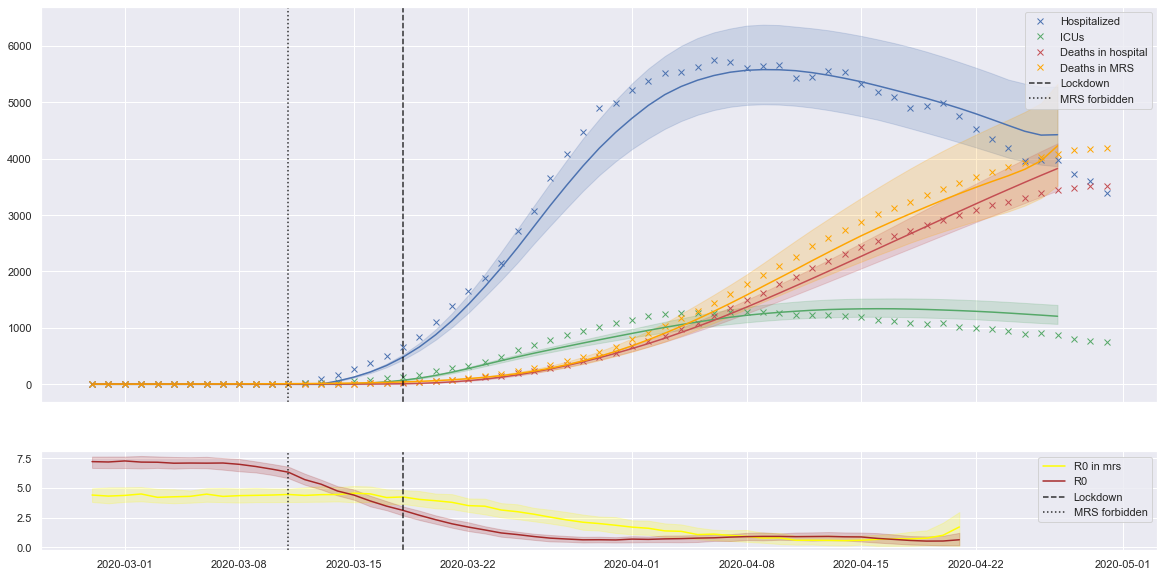

In [21]:
def get_percentiles(arr, color=None,ax=None, label=None):
    arr_50 = np.percentile(arr, 50, axis=1)
    arr_5 = np.percentile(arr, 5, axis=1)
    arr_95 = np.percentile(arr, 95, axis=1)
    if color is not None:
        ax.plot(data_df['date'][:len(arr)], arr_50, c=color, label=label)
        ax.fill_between(data_df['date'][:len(arr)], arr_5, arr_95, color=color, alpha=0.2)
    return arr_50, arr_5, arr_95

seaborn.set()
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={"height_ratios": (4, 1)})

ax[0].plot(data_df['date'], data_df['n_hospitalized'], 'x', color='b', label='Hospitalized')

ax[0].plot(data_df['date'], data_df['n_icu'], 'x', color='g', label='ICUs')
ax[0].plot(data_df['date'], data_df['n_deaths'] * frac_dh().item(), 'x', color='r', label='Deaths in hospital')
ax[0].plot(data_df['date'], data_df['n_deaths']*(1-frac_dh().item()), 'x', color='orange', label='Deaths in MRS')

get_percentiles(h, 'b', ax[0])
get_percentiles(l, 'g', ax[0])
get_percentiles(m, 'r', ax[0])
get_percentiles(m_mrs, 'orange', ax[0])

get_percentiles(r0_mrs[:-n_unpredictable_days-1], 'yellow', ax[1], "R0 in mrs")
get_percentiles(r0[:-n_unpredictable_days-1], 'brown', ax[1], 'R0')

ax[0].axvline(data_df['date'][date_r0_switch], 0, 8500, label='Lockdown', c='black', alpha=.8, linestyle ='--')
ax[0].axvline(data_df['date'][date_r0_switch_mrs], 0, 8500, label='MRS forbidden', c='black', alpha=.8, linestyle=':')
ax[1].axvline(data_df['date'][date_r0_switch], 0, 8500, label='Lockdown', c='black', alpha=.8, linestyle ='--')
ax[1].axvline(data_df['date'][date_r0_switch_mrs], 0, 8500, label='MRS forbidden', c='black', alpha=.8, linestyle=':')

ax[0].legend()
ax[1].legend()

plt.savefig('pyro_SEIR_manyR0.png')
plt.show()

In [20]:
def mcmc_seir_full_model_bis(data):
    return pyro.condition(SEIR_full_model_bis, data=data)()

In [ ]:
%%time
nuts_kernel = NUTS(mcmc_seir_full_model_bis, jit_compile=False, ignore_jit_warnings=True)
pyro.set_rng_seed(1)
mcmc = MCMC(nuts_kernel, num_samples=100)
mcmc.run(data)
mcmc.summary(prob=.5)